# Playing with UCI Bike Sharing Data

Links:
- [Data source](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

In [246]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.optimize import brute
from scipy.stats import norm
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from download_data import download_data

Download data from the source to the local `data` directory

In [ ]:
local_data_dir = download_data()

Import data

In [8]:
raw_data_path = local_data_dir / "day.csv"
lbl_date = "dteday"
lbl_count_of_rental_bikes = "cnt"
raw_data = pd.read_csv(raw_data_path, parse_dates=[lbl_date])
raw_data.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


In [9]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   dteday      731 non-null    datetime64[ns]
 2   season      731 non-null    int64         
 3   yr          731 non-null    int64         
 4   mnth        731 non-null    int64         
 5   holiday     731 non-null    int64         
 6   weekday     731 non-null    int64         
 7   workingday  731 non-null    int64         
 8   weathersit  731 non-null    int64         
 9   temp        731 non-null    float64       
 10  atemp       731 non-null    float64       
 11  hum         731 non-null    float64       
 12  windspeed   731 non-null    float64       
 13  casual      731 non-null    int64         
 14  registered  731 non-null    int64         
 15  cnt         731 non-null    int64         
dtypes: datetime64[ns](1), floa

In [18]:
raw_data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [20]:
raw_data.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [180]:
split_time = raw_data[lbl_date].max() - pd.DateOffset(days=30)
data_train = raw_data.pipe(lambda df: df[df[lbl_date] < split_time])
data_test = raw_data.pipe(lambda df: df[df[lbl_date] >= split_time])
y_train = data_train[lbl_count_of_rental_bikes]
y_test = data_test[lbl_count_of_rental_bikes]

data_train.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
695,696,2012-11-26,4,1,11,0,1,1,1,0.313333,0.339004,0.535417,0.046650,337,4750,5087
696,697,2012-11-27,4,1,11,0,2,1,2,0.291667,0.281558,0.786667,0.237562,123,3836,3959
697,698,2012-11-28,4,1,11,0,3,1,1,0.296667,0.289762,0.506250,0.210821,198,5062,5260
698,699,2012-11-29,4,1,11,0,4,1,1,0.280870,0.298422,0.555652,0.115522,243,5080,5323
699,700,2012-11-30,4,1,11,0,5,1,1,0.298333,0.323867,0.649583,0.058471,362,5306,5668


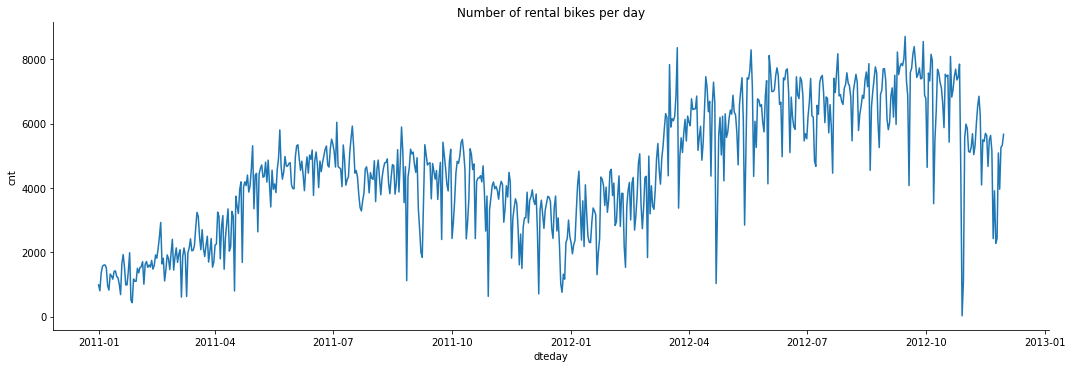

In [17]:
sns.relplot(
    x=lbl_date,
    y=lbl_count_of_rental_bikes,
    kind="line",
    aspect=3,
    data=data_train
)
plt.title("Number of rental bikes per day")
plt.show()

In [24]:
MAX_RENTALS_PER_BIKE_PER_DAY = 12
lbl_nr_of_bikes_needed_per_day = "number of bikes needed per day"
data_train = data_train.assign(
    **{lbl_nr_of_bikes_needed_per_day: lambda df: df[lbl_count_of_rental_bikes] / MAX_RENTALS_PER_BIKE_PER_DAY}
)

In [26]:
max_nr_of_bikes_needed = data_train[lbl_nr_of_bikes_needed_per_day].max()
print(f"Max number of bikes needed over all days in the data: {max_nr_of_bikes_needed:.0f}")

Max number of bikes needed over all days in the data: 726


In [33]:
alpha = 0.95
quantile_nr_of_bikes_needed = data_train[lbl_nr_of_bikes_needed_per_day].quantile(alpha)

print(f"{alpha:.0%} quantile number of bikes needed over all days in the data: {quantile_nr_of_bikes_needed:.0f}")

95% quantile number of bikes needed over all days in the data: 632


In [38]:
grid_bikes_available = np.linspace(start=0, stop=max_nr_of_bikes_needed, num=10)

In [50]:
def get_pct_days_covered(data: pd.DataFrame, bikes_available: int) -> float:
    return 100 * (data[lbl_nr_of_bikes_needed_per_day] <= bikes_available).sum() / data.shape[0]


lbl_pct_bikes_available = "pct bikes available"
lbl_days_covered = "pct days covered"
pct_days_covered = list()
for bikes_available in grid_bikes_available:
    pct_days_covered.append(
        {lbl_pct_bikes_available: 100 * bikes_available / max_nr_of_bikes_needed,
         lbl_days_covered: get_pct_days_covered(data=data_train, bikes_available=bikes_available)}
    )
pct_days_covered = pd.DataFrame(pct_days_covered)
pct_days_covered

,pct bikes available,pct days covered
0,0.000000,0.000000
1,11.111111,1.857143
2,22.222222,12.000000
3,33.333333,22.142857
4,44.444444,35.857143
5,55.555556,58.285714
6,66.666667,72.428571
7,77.777778,82.857143
8,88.888889,97.000000
9,100.000000,100.000000


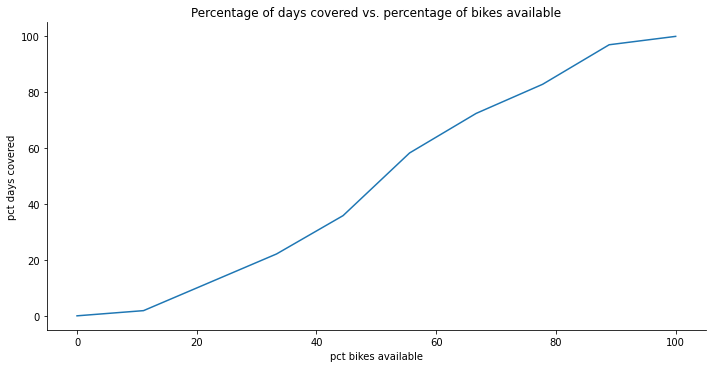

In [52]:
sns.relplot(
    x=lbl_pct_bikes_available,
    y=lbl_days_covered,
    kind="line",
    aspect=2,
    data=pct_days_covered,
)
plt.title("Percentage of days covered vs. percentage of bikes available")
plt.show()

## Model train/fit/score

In [192]:
%%time

lbl_prediction = "prediction"
lbl_holiday = "holiday"
lbl_weekday = "weekday"
lbl_workingday = "workingday"
lbl_weathersit = "weathersit"
lbl_season = "season"
lbl_temp = "temp"
lbl_hum = "hum"
lbl_windspeed = "windspeed"

continuous_features = [lbl_temp, lbl_hum, lbl_windspeed]
binary_features = [lbl_holiday, lbl_workingday]
categorical_features = [lbl_season, lbl_weathersit]

categorical_transformer = OneHotEncoder(sparse=False)
numeric_transformer = StandardScaler()
data_transformer = ColumnTransformer(
    transformers=[
        ("binary features", "passthrough", binary_features + continuous_features),
        ("categorical features", categorical_transformer, categorical_features)
    ], remainder="drop"
)
model = RandomForestRegressor(n_estimators=5, random_state=0)
pipeline = make_pipeline(data_transformer, model)

pipeline.fit(X=data_train, y=y_train)

r2_initial = pipeline.score(X=data_train, y=y_train)
print(f"initial R2 = {r2_initial:.0%}")

initial R2 = 91%
CPU times: user 40.1 ms, sys: 7 µs, total: 40.2 ms
Wall time: 40 ms


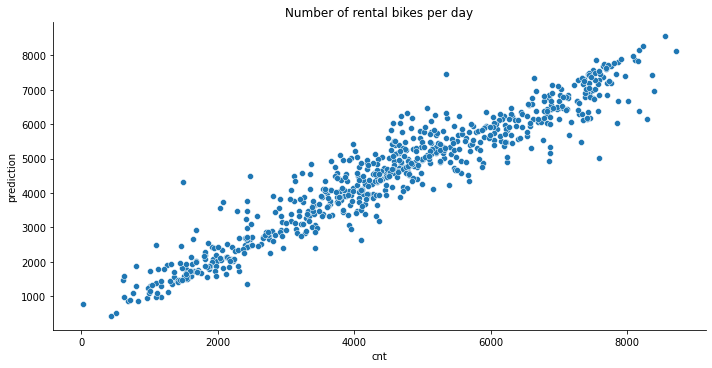

In [186]:
data_with_predictions = data_train.assign(
    **{lbl_prediction: pipeline.predict(X=data_train)}
)

sns.relplot(
    x=lbl_count_of_rental_bikes,
    y=lbl_prediction,
    aspect=2,
    data=data_with_predictions
)

plt.title("Number of rental bikes per day")
plt.show()

## Hyperparameter tuning

In [187]:
pipeline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('binary features', 'passthrough',
                                    ['holiday', 'workingday', 'temp', 'hum',
                                     'windspeed']),
                                   ('categorical features',
                                    OneHotEncoder(sparse=False),
                                    ['season', 'weathersit'])])),
  ('randomforestregressor',
   RandomForestRegressor(n_estimators=5, random_state=0))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('binary features', 'passthrough',
                                  ['holiday', 'workingday', 'temp', 'hum',
                                   'windspeed']),
                                 ('categorical features',
                                  OneHotEncoder(sparse=False),
                                  ['season', 'weathersit'])]),
 'randomforestregressor': RandomForestRegressor(n_estim

In [188]:
%%time

param_grid = [{"randomforestregressor__n_estimators": [5, 10, 50]}]
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring="r2")
grid_search.fit(X=data_train, y=y_train)
grid_search_results = pd.DataFrame(grid_search.cv_results_)

CPU times: user 1.48 s, sys: 3.17 ms, total: 1.48 s
Wall time: 1.59 s


In [189]:
grid_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032968,0.009432,0.007279,0.000879,5,{'randomforestregressor__n_estimators': 5},-1.159810,-6.216784,-1.754984,-1.413818,-1.648976,-2.438875,1.900052,3
1,0.031950,0.001192,0.005336,0.000277,10,{'randomforestregressor__n_estimators': 10},-1.074323,-6.234915,-1.673802,-1.431736,-1.570447,-2.397045,1.929611,2
2,0.184821,0.038334,0.015562,0.006208,50,{'randomforestregressor__n_estimators': 50},-1.116664,-6.018385,-1.339990,-1.408098,-1.375075,-2.251642,1.886137,1


In [193]:
best_model = grid_search.best_estimator_
r2_best = best_model.score(X=data_train, y=y_train)
print(f"Initial R2 = {r2_initial:.0%}")
print(f"Best R2 = {r2_best:.0%}")
print(f"R2 improvement: {r2_best - r2_initial:.2%}")

Initial R2 = 91%
Best R2 = 94%
R2 improvement: 3.17%


## Profit optimization

In [239]:
REVENUE_PER_RENTAL = 10
BIKE_COST_PER_DAY = 7

np.random.seed(42)

predictions = best_model.predict(X=data_test)
residuals = y_test - predictions
simulated_residuals = norm.rvs(loc=residuals.mean(), scale=residuals.std(), size=predictions.shape[0])
simulated_demand = (predictions + simulated_residuals) / MAX_RENTALS_PER_BIKE_PER_DAY

def compute_profit(bikes_available: int) -> float:
    satisfied_demand = np.where(simulated_demand < bikes_available, simulated_demand, bikes_available)
    return (satisfied_demand * REVENUE_PER_RENTAL - bikes_available * BIKE_COST_PER_DAY).sum()

profit_for_max_nr_of_bikes_needed = compute_profit(bikes_available=max_nr_of_bikes_needed)
print(f"Profit for maximum available number of bikes: {profit_for_max_nr_of_bikes_needed:.0f}")

Profit for maximum available number of bikes: -60247


In [240]:
profit = list()
lbl_profit = "profit"

for bikes_available in grid_bikes_available:
    profit.append(
        {lbl_pct_bikes_available: bikes_available / max_nr_of_bikes_needed,
         lbl_profit: compute_profit(bikes_available=bikes_available)}
    )
profit = pd.DataFrame(profit)

In [256]:
%%time

def compute_loss(bikes_available: int) -> float:
    return -compute_profit(bikes_available=bikes_available)

grid = (slice(0, max_nr_of_bikes_needed, max_nr_of_bikes_needed / 10),)
opt_result = brute(func=compute_loss, ranges=grid, full_output=True)
opt_result

CPU times: user 6.46 ms, sys: 0 ns, total: 6.46 ms
Wall time: 7.74 ms


(array([237.17427329]),
 -16431.461314438347,
 array([  0.        ,  72.61666667, 145.23333333, 217.85      ,
        290.46666667, 363.08333333, 435.7       , 508.31666667,
        580.93333333, 653.55      ]),
 array([    -0.        ,  -6753.35      , -12678.67277988, -16317.64842446,
        -14634.93619506,  -7853.56335944,   2071.62394289,  14267.65655058,
         29069.60954355,  44488.94363015]))

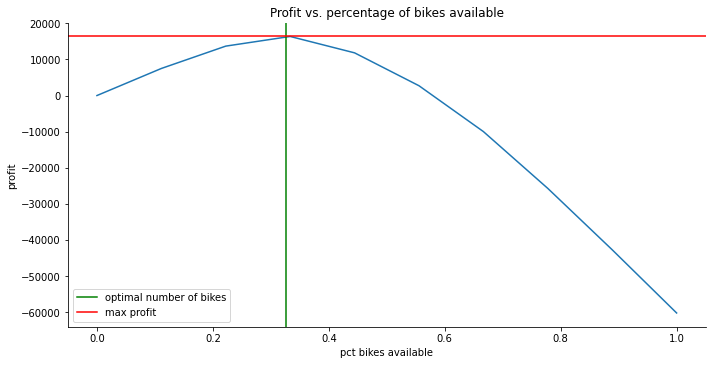

In [259]:
sns.relplot(
    x=lbl_pct_bikes_available,
    y=lbl_profit,
    kind="line",
    aspect=2,
    data=profit,
)
plt.axvline(opt_result[0] / max_nr_of_bikes_needed, color="green", label="optimal number of bikes")
plt.axhline(-opt_result[1], color="r", label="max profit")
plt.title("Profit vs. percentage of bikes available")
plt.legend()
plt.show()